In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NUM_CLASSES = 20
EPOCHS = 2
LR = 0.001
BATCH_SIZE = 64


class SubsetCIFAR100(torchvision.datasets.CIFAR100):
    def __init__(self, root, train, transform, download):
        super().__init__(root=root, train=train, transform=transform, download=download)
        indices = [i for i, t in enumerate(self.targets) if t < NUM_CLASSES]
        self.data = self.data[indices]
        self.targets = [self.targets[i] for i in indices]

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

trainset = SubsetCIFAR100(root='./data', train=True, download=True, transform=transform)
testset = SubsetCIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


activations = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Softmax': nn.Softmax(dim=1)
}


model_dict = {
    "MobileNet": models.mobilenet_v2,
    "MobileNetV2": models.mobilenet_v2,
    "ResNet50": models.resnet50,
    "ResNet50V2": models.resnet50,
    "ResNet101": models.resnet101,
    "ResNet101V2": models.resnet101,
    "ResNet152": models.resnet152,
    "ResNet152V2": models.resnet152,
    "VGG16": models.vgg16,
    "VGG19": models.vgg19,
}


def modify_model(name, act_fn):
    base_model = model_dict[name](pretrained=True)
    for param in base_model.parameters():
        param.requires_grad = False

    if name.startswith("ResNet") or name.startswith("resnet"):
        in_features = base_model.fc.in_features
        base_model.fc = nn.Sequential(
            nn.Linear(in_features, NUM_CLASSES),
            act_fn
        )
    elif name.startswith("MobileNet"):
        in_features = base_model.classifier[1].in_features
        base_model.classifier[1] = nn.Sequential(
            nn.Linear(in_features, NUM_CLASSES),
            act_fn
        )
    elif name.startswith("VGG"):
        in_features = base_model.classifier[6].in_features
        base_model.classifier[6] = nn.Sequential(
            nn.Linear(in_features, NUM_CLASSES),
            act_fn
        )
    else:
        raise ValueError(f"Model {name} not supported.")
    
    return base_model.to(device)

#eval
def evaluate(model, loader, loss_fn, act_name):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if act_name == 'Sigmoid':
                labels = nn.functional.one_hot(labels, NUM_CLASSES).float()
                outputs = torch.sigmoid(outputs) 
                predictions = torch.argmax(outputs, dim=1)
            else:
                predictions = torch.argmax(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            correct += (predictions == labels.argmax(dim=1) if act_name == 'Sigmoid' else predictions == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total, total_loss / len(loader)


results = {act: {} for act in activations}

#train
for act_name, act_fn in activations.items():
    print(f"\n=== Activation: {act_name} ===")
    for model_name in model_dict:
        try:
            print(f" → {model_name}")
            model = modify_model(model_name, act_fn)
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
            
            #select loss function
            if act_name == 'Sigmoid':
                criterion = nn.BCEWithLogitsLoss()
            else:
                criterion = nn.CrossEntropyLoss()

           
            model.train()
            for epoch in range(EPOCHS):
                for images, labels in trainloader:
                    images, labels = images.to(device), labels.to(device)

                    if act_name == 'Sigmoid':
                        labels = nn.functional.one_hot(labels, NUM_CLASSES).float()

                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            # Evaluate
            acc, loss_val = evaluate(model, testloader, criterion, act_name)
            print(f"   Accuracy: {acc:.2f}% | Loss: {loss_val:.4f}")
            results[act_name][model_name] = acc
        except Exception as e:
            print(f"   Skipped {model_name}: {e}")


Files already downloaded and verified
Files already downloaded and verified

=== Activation: ReLU ===
 → MobileNet


d:\sangita-mam\yolov1_widerface\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\sangita-mam\yolov1_widerface\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


   Accuracy: 33.75% | Loss: 2.1909
 → MobileNetV2
   Accuracy: 42.00% | Loss: 2.1027
 → ResNet50


d:\sangita-mam\yolov1_widerface\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


   Accuracy: 16.90% | Loss: 2.7231
 → ResNet50V2
   Accuracy: 28.70% | Loss: 2.3965
 → ResNet101


d:\sangita-mam\yolov1_widerface\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


   Accuracy: 23.60% | Loss: 2.4739
 → ResNet101V2
   Accuracy: 50.60% | Loss: 1.7947
 → ResNet152


d:\sangita-mam\yolov1_widerface\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


   Accuracy: 45.00% | Loss: 1.9539
 → ResNet152V2
   Accuracy: 41.55% | Loss: 2.0888
 → VGG16


d:\sangita-mam\yolov1_widerface\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


   Accuracy: 18.35% | Loss: 2.5968
 → VGG19


d:\sangita-mam\yolov1_widerface\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


   Accuracy: 36.20% | Loss: 2.3064

=== Activation: Sigmoid ===
 → MobileNet
   Accuracy: 6.60% | Loss: 0.9491
 → MobileNetV2
   Accuracy: 7.00% | Loss: 0.9491
 → ResNet50
   Accuracy: 7.45% | Loss: 0.9491
 → ResNet50V2
   Accuracy: 3.55% | Loss: 0.9491
 → ResNet101
   Accuracy: 7.00% | Loss: 0.9491
 → ResNet101V2
   Accuracy: 3.60% | Loss: 0.9491
 → ResNet152
   Accuracy: 5.45% | Loss: 0.9491
 → ResNet152V2
   Accuracy: 7.65% | Loss: 0.9491
 → VGG16
   Accuracy: 9.60% | Loss: 0.9491
 → VGG19
   Accuracy: 13.25% | Loss: 0.9491

=== Activation: Softmax ===
 → MobileNet
   Accuracy: 66.10% | Loss: 2.4720
 → MobileNetV2
   Accuracy: 65.65% | Loss: 2.4754
 → ResNet50
   Accuracy: 65.55% | Loss: 2.4687
 → ResNet50V2
   Accuracy: 65.00% | Loss: 2.4689
 → ResNet101
   Accuracy: 71.50% | Loss: 2.4074
 → ResNet101V2
   Accuracy: 65.65% | Loss: 2.4551
 → ResNet152
   Accuracy: 64.00% | Loss: 2.4701
 → ResNet152V2
   Accuracy: 64.25% | Loss: 2.4723
 → VGG16
   Accuracy: 62.10% | Loss: 2.5081
 → V

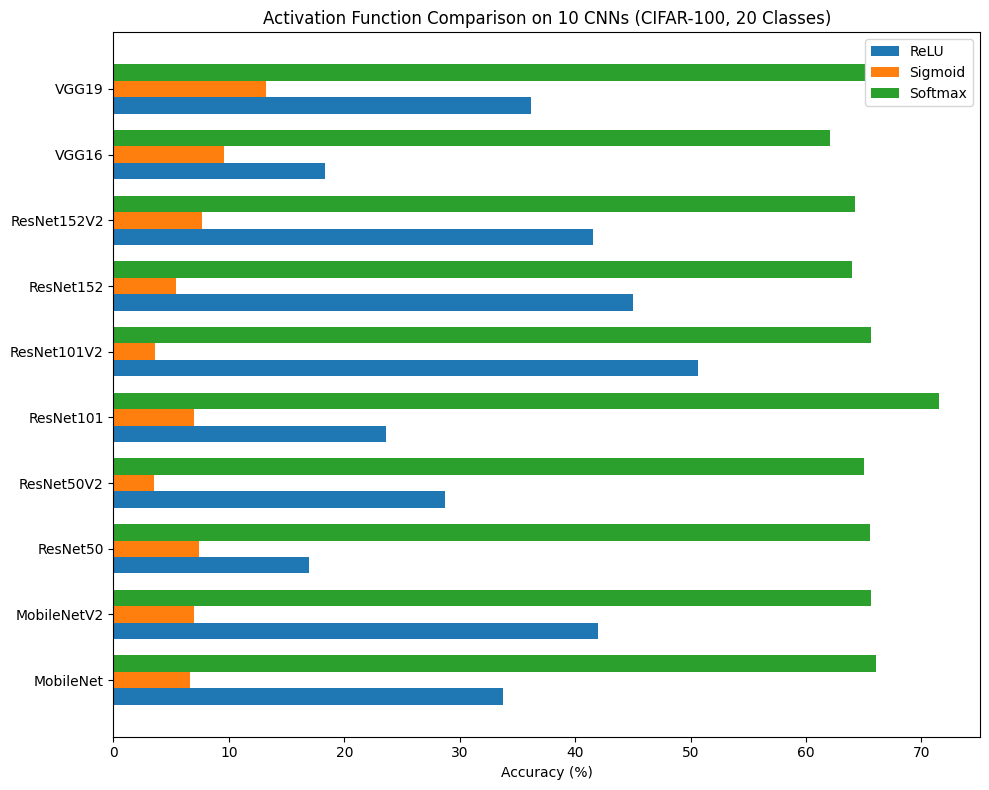

In [49]:
labels = list(model_dict.keys())
y = np.arange(len(labels))
height = 0.25

fig, ax = plt.subplots(figsize=(10, 8))

for i, (act_name, model_accs) in enumerate(results.items()):
    acc_list = [model_accs.get(m, 0) for m in labels]
    ax.barh(y + i * height, acc_list, height, label=act_name)

ax.set_xlabel('Accuracy (%)')
ax.set_title('Activation Function Comparison on 10 CNNs (CIFAR-100, 20 Classes)')
ax.set_yticks(y + height)
ax.set_yticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
def show_one_image_per_class(dataset, num_classes=20):
    cifar100_classes_0_19 = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver',
        'bed', 'bee', 'beetle', 'bicycle', 'bottle',
        'bowl', 'boy', 'bridge', 'bus', 'butterfly',
        'cactus', 'camel', 'can', 'castle', 'caterpillar'
    ]

    shown = set()
    class_images = []

    for img, label in dataset:
        if label not in shown:
            shown.add(label)
            class_images.append((img, label))
        if len(shown) == num_classes:
            break

    plt.figure(figsize=(15, 6))
    for i, (img, label) in enumerate(class_images):
        img_np = img.permute(1, 2, 0).numpy()  
        plt.subplot(2, 10, i + 1)
        plt.imshow(img_np)
        plt.title(f"{label}: {cifar100_classes_0_19[label]}", fontsize=9)
        plt.axis("off")

    plt.suptitle("One Sample from Each of the First 20 CIFAR-100 Classes", fontsize=16)
    plt.tight_layout()
    plt.show()


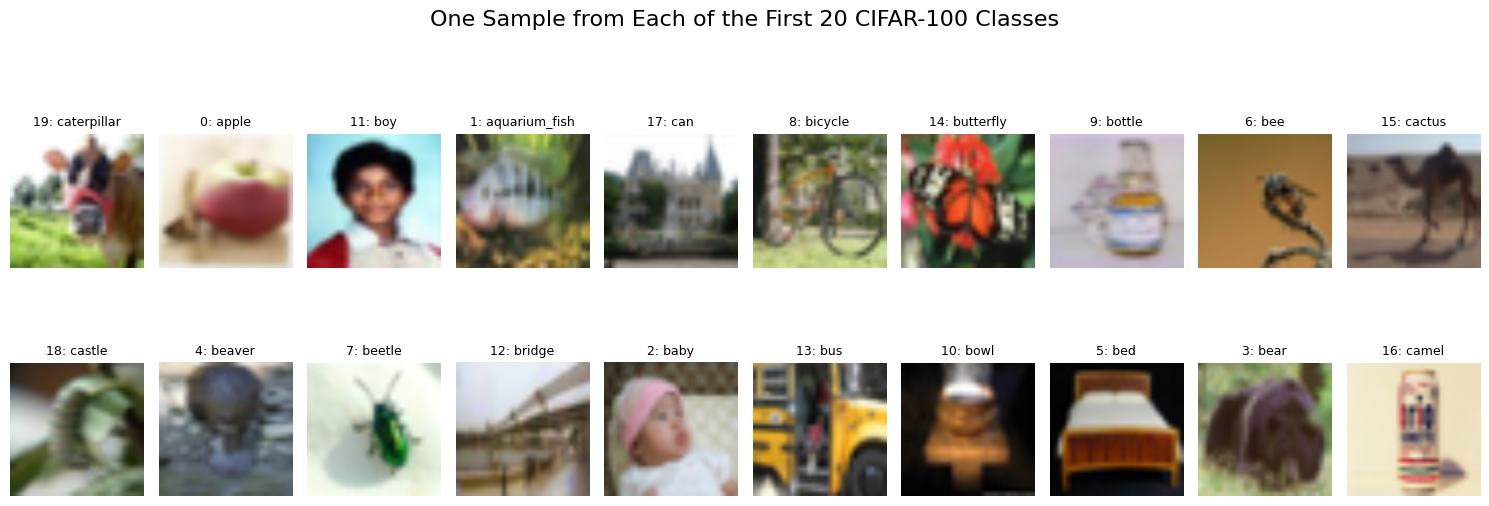

In [52]:
show_one_image_per_class(trainset)
